### Problem Statement

*Predicting housing prices is of interest to potential buyers, sellers, and organizations alike. Multiple online platforms offer, for example, a free “price estimate” based on underlying machine learning models. For this assignment, we are going to build the best machine learning model we can for Ames, Iowa. The data set consists of 79 features that describe the quality and quantity of the properties to base our predictions on.*

# Task 0: Data Preperation

*Note: No code has to be written for the 5 cells below - you may just execute them sequentially. After this, you may move on to **Task 1** on understanding the data.*

In [215]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

from scipy.stats import pearsonr

In [216]:
# All missing data removed/cleaned
housing_df = pd.read_csv(r'D:\Graded\ames_data_no_missing.csv', index_col=0)
housing_df.head()

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Lot Config,Land Slope,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
PID,,,,,,,,,,,,,,,,,,,,,
526301100,20,RL,141.0,31770,Pave,None,IR1,Lvl,Corner,Gtl,...,0,None,None,None,0,5,2010,WD,Normal,215000
526350040,20,RH,80.0,11622,Pave,None,Reg,Lvl,Inside,Gtl,...,0,None,MnPrv,None,0,6,2010,WD,Normal,105000
526351010,20,RL,81.0,14267,Pave,None,IR1,Lvl,Corner,Gtl,...,0,None,None,Gar2,12500,6,2010,WD,Normal,172000
526353030,20,RL,93.0,11160,Pave,None,Reg,Lvl,Corner,Gtl,...,0,None,None,None,0,4,2010,WD,Normal,244000
527105010,60,RL,74.0,13830,Pave,None,IR1,Lvl,Inside,Gtl,...,0,None,MnPrv,None,0,3,2010,WD,Normal,189900


In [217]:
#Check the number of dummies to be created
count = [housing_df[col].nunique() for col in housing_df.columns if housing_df[col].dtype==object]
sum(count)

279

In [218]:
# ensure Python reads the categorical variables as categorical
for column in housing_df.columns:
    if housing_df[column].dtype == 'object':
        housing_df[column] = pd.Categorical(housing_df[column])

In [219]:
#define our RMSE function
def rmse(y_train, y_pred):
    return np.sqrt(mean_squared_error(y_train, y_pred))


# Task 1: Understand the Data
*Take some time to familiarize yourself with the data. It contains information about housing prices in Ames. What are the key variables?*

*You may perform any additional EDA if necessary.*

### 1.1
*What is the distribution of housing prices?*

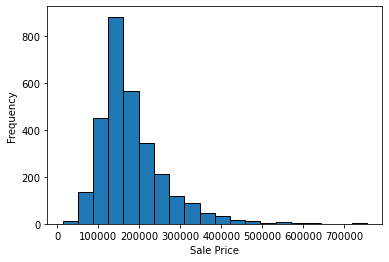

In [220]:
# The original distribution
housing_prices = "SalePrice"
data, housing = housing_df.drop(columns=housing_prices), housing_df[housing_prices]
housing.head() 
# plotting a histogram
housing.plot.hist(bins=20, edgecolor="black")
plt.xlabel("Sale Price")
plt.show()

### 1.2
*What is the variable that has the highest correlation with Housing prices? What are the key drivers behind larger house prices?*

In [221]:
#Find the correlations of all variables with SalePrice

housing_corr = housing_df.corr()
corr_df = pd.DataFrame(housing_df.corr()['SalePrice'].sort_values(ascending=False)).reset_index()
corr_df


,index,SalePrice
0,SalePrice,1.000000
1,Overall Qual,0.799262
2,Gr Liv Area,0.706780
3,Garage Cars,0.647562
4,Garage Area,0.640138
5,Total Bsmt SF,0.632529
6,1st Flr SF,0.621676
7,Year Built,0.558426
8,Full Bath,0.545604
9,Year Remod/Add,0.532974


**As per the heatmap, the sale price has the highest correlation with Overall Quality in the housing. Secondly the biggest key driver of larger housing prices can be seen as the Groung Living area.**

### 1.3
*Create one additional visualization, that gives some insights into the data.*

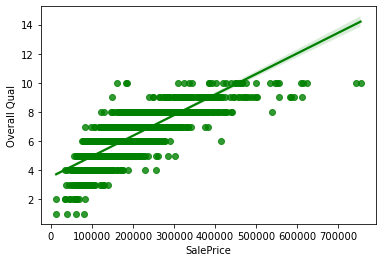

In [222]:
# Create a visualization to highlight any insight - Can be a scatter plot, line plot, box plot, histogram or any other visualization that you might know!

housing_insight = sns.regplot(data=housing_df, x="SalePrice", y="Overall Qual", color="green")

# Task 2: Build machine learning models

*Use your knowledge of prediction models to create at least three models that predict housing prices.*

### 2.1 
1. *Create dummies for all the categorical columns*.

2. *Partition your data into training and validation (70-30 split, setting the random state to 1).*
3. *Scale the train and the test set using StandardScaler()*

In [223]:
# Initialize X and y
X = housing_df.drop(columns=['SalePrice']) # All but the outcome column
y = housing_df['SalePrice']

In [224]:
# Use dummy variables for categorical variables

X = pd.get_dummies(X, drop_first=False)

In [225]:
# Train - Test split (70-30 split, setting the random state to 1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state = 1)

In [226]:
# Scale the train and test set features separately
scaler = StandardScaler()
numeric_cols = [col for col in X.columns if X[col].dtypes != 'category']

X_scaled = scaler.fit_transform(X)

Xs_train, Xs_val = train_test_split(X_scaled, test_size=0.3, random_state = 1)

In [227]:
# Filter warnings
import warnings 
warnings.filterwarnings('ignore')

### 2.2
*Build a linear regression model, a regression tree and a kNN model. Carefully apply regularization for the linear regression model. Carefully select which variables to use for the kNN model.*

In [228]:
# Linear model - USE LassoCV to get the best LASSO model
alphas = np.arange(.01, 25, .25)
lasso_housing_model = LassoCV(alphas= alphas, cv=5, max_iter=50000)
lasso_housing_model.fit(Xs_train, y_train)

lasso_best = Lasso(alpha = lasso_housing_model.alpha_)
lasso_best.fit(Xs_train, y_train)

Lasso(alpha=23.26)

In [229]:
# Tree Model - Use max depth to control the complexity of the tree. Run a Grid search for multiple values of max depth.
X = housing_df.drop(columns=['SalePrice']) # All but the outcome column
y = housing_df['SalePrice']

X = pd.get_dummies(X, drop_first=False)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state = 1)

tree_reg = DecisionTreeRegressor(random_state = 0)
tree_reg = tree_reg.fit(X_train, y_train)

# Define the range of the max_depth parameter
param_grid = {'max_depth': np.arange(1, 6)} # Parameter range

# Perform grid search
grid = GridSearchCV(tree_reg , param_grid, cv = 5, scoring = 'neg_mean_squared_error', return_train_score = False, verbose = 1)
grid_search = grid.fit(X_train, y_train)
#Tree Model 
grid_search.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


{'max_depth': 5}

In [230]:
# KNN Model

# Select the top 20 most correlated features and store it in a list called 'top_20_features' (using similar correlation table from Task 1)
housing_corr = housing_df.corr()
corr_df = pd.DataFrame(housing_df.corr()['SalePrice'].sort_values(ascending=False)).reset_index()
corr_df
top_20_features = list(corr_df.loc[:20]['index']) # Selecting the top 20 features

#For building the model, you must use X_train[top_20_features]
X = top_20_features
y = housing_df['SalePrice']


scaler = StandardScaler()

X_train=scaler.fit_transform(X_train)
X_val=scaler.transform(X_train)

    
# Find the value of k for which RMSE is minimum, using GridSearchCV
knn_reg = KNeighborsRegressor()
param_grid = {'n_neighbors': np.arange(1,20)} # Parameter range
  
# defining parameter range
grid = GridSearchCV(knn_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=False, verbose=1)
grid_search = grid.fit(X_train, y_train)

grid_search.best_params_

Fitting 5 folds for each of 19 candidates, totalling 95 fits


{'n_neighbors': 8}

### 2.3
*Summarize the predictive performance in terms of RMSE.* 
1. *Calculate the RMSE values for train and validation for all the models*
2. *Display them in a tabulated format*

Hint: You may use the code that you've learnt in the 'Model selection' module

In [231]:
#linear regression

alphas = np.arange(.01, 25, .25)
lasso_housing_model = LassoCV(alphas= alphas, cv=5, max_iter=50000)
lasso_housing_model.fit(Xs_train, y_train)

lasso_best = Lasso(alpha = lasso_housing_model.alpha_)
lasso_best.fit(Xs_train, y_train)

lin_train_rmse = round(rmse(y_train, lasso_best.predict(Xs_train)))
lin_val_rmse = round(rmse(y_val, lasso_best.predict(Xs_val)))

#max depth pruned tree
tree_reg = DecisionTreeRegressor(max_depth=5, random_state = 0)
tree_reg = tree_reg.fit(X_train, y_train)


# Calculate RMSE for the best tree
tree_train_rmse = round(rmse(y_train, tree_reg.predict(X_train)))
tree_val_rmse = round(rmse(y_val, tree_reg.predict(Xs_val)))



#knn

knn = KNeighborsRegressor(n_neighbors=8)
knn.fit(X_train, y_train)

knn_train_rmse = round(rmse(y_train, knn.predict(X_train)))
knn_val_rmse = round(rmse(y_val, knn.predict(Xs_val)))
#Display the RMSEs

pd.DataFrame([[lin_train_rmse,lin_val_rmse],[tree_train_rmse, tree_val_rmse],[knn_train_rmse,knn_val_rmse]], columns = ['Train','Validation'], index = ['Lin Reg', 'Reg Tree', 'kNN'])



,Train,Validation
Lin Reg,20672,22315
Reg Tree,30285,34206
kNN,33216,36779


### 2.4
*Study the largest errors that you made (largest overpredictions, largest underpredictions). What may be some of the reasons why the model is over/under predicting? Do these insights possibly help you improve the models?*

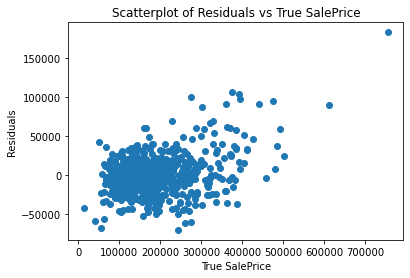

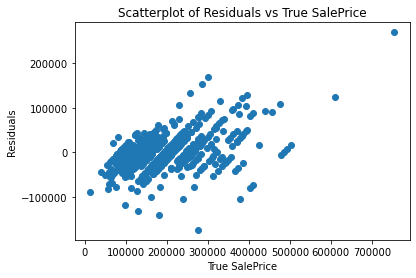

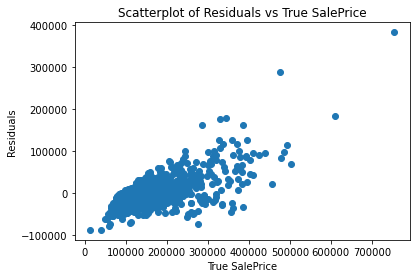

In [232]:
# Visualize the errors - plot a scatterplot of the residuals vs the true SalePrice

lasso_best = Lasso(alpha = lasso_housing_model.alpha_)
lasso_best.fit(Xs_train, y_train)

y_val_pred=lasso_best.predict(Xs_val)

residuals_lasso = y_val - y_val_pred

tree_reg = DecisionTreeRegressor(max_depth=5, random_state = 0)
tree_reg = tree_reg.fit(X_train, y_train)

y_val_pred=tree_reg.predict(Xs_val)

residuals_tree = y_val - y_val_pred

knn = KNeighborsRegressor(n_neighbors=8)
knn.fit(X_train, y_train)

y_val_pred=knn.predict(Xs_val)

residuals_knn = y_val - y_val_pred

plt.scatter(y_val, residuals_lasso)
plt.xlabel("True SalePrice")
plt.ylabel("Residuals")
plt.title("Scatterplot of Residuals vs True SalePrice")
plt.show()

plt.scatter(y_val, residuals_tree)
plt.xlabel("True SalePrice")
plt.ylabel("Residuals")
plt.title("Scatterplot of Residuals vs True SalePrice")
plt.show()

plt.scatter(y_val, residuals_knn)
plt.xlabel("True SalePrice")
plt.ylabel("Residuals")
plt.title("Scatterplot of Residuals vs True SalePrice")
plt.show()

# Task 3

### 3.1
*Are you able to improve your linear regression model by taking the log of the dependent variable? (remember to translate your predicted outcome back to the original units before calculating the RMSE)*

*Create a visualization, that highlights the distribution of prices when after taking log of the dependent variable*

Hint - You may use [numpy.log()](https://numpy.org/doc/stable/reference/generated/numpy.log.html) to get the log of the dependent variable

In [233]:
# distribution of the transformed SalePrice

y_train_log = np.log(y_train)


In [234]:
# Linear model - Using the log of the SalePrice as the dependent variable, run the LassoCV to obtain the best LASSO model
# Note that the optimum value of Alpha for this model would also be scaled down to a log scale. It's a better idea to simply search for the best alpha once again using LassoCV.

alphas = np.arange(.01, 25, .25)
lasso_housing_model = LassoCV(alphas= alphas, cv=5, max_iter=50000)
lasso_housing_model.fit(Xs_train, y_train_log)



y_val_pred_log = lasso_housing_model.predict(X_val)

In [235]:
# Calculate the RMSE values for train and the test set

lin_train_rmse = round(rmse(y_train, lasso_housing_model.predict(Xs_train)))
lin_val_rmse = round(rmse(y_val, lasso_housing_model.predict(Xs_val)))

In [236]:
# Display the RMSE values in a dataframe

pd.DataFrame([[lin_train_rmse,lin_val_rmse]], columns = ['Train','Validation'], index = ['Lin Reg'])

,Train,Validation
Lin Reg,199211,193932


### 3.2 Bonus Task
*Experiment with data segmentation: Should you subset the data and fit separate models for each subset?*

Data segmentation is generally useful when we think that subsegments of our data have substantially different relationships between their features and the outcome compared to other subsegments (i.e variable interactions). We can use a combination of prior knowledge and data exploration to build our domain knowledge about where this situation would apply.

Starting with prior knowledge, you can hypothesize $HouseStyle$ may be a candidate for data segmentation, as for instance, 3 bedrooms in a 1-story house may have a different effect on $SalePrice$ than 3 bedrooms in a 2-story house.

In [237]:
housing_df['House Style'].value_counts()

1Story    1481
2Story     873
1.5Fin     314
SLvl       128
SFoyer      83
2.5Unf      24
1.5Unf      19
2.5Fin       8
Name: House Style, dtype: int64

In [238]:
housing_df['Bedroom AbvGr'].value_counts()

3    1597
2     743
4     400
1     112
5      48
6      21
0       8
8       1
Name: Bedroom AbvGr, dtype: int64

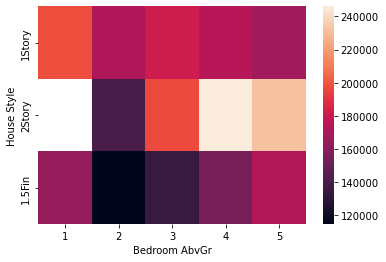

In [239]:
matrix = []
styles = ['1Story', '2Story', '1.5Fin']
for style in styles:
    curr_style = []
    for bedrooms in range(1, 6):
        curr_mean = housing_df[(housing_df['House Style'] == style) & 
                               (housing_df['Bedroom AbvGr'] == bedrooms)]['SalePrice'].mean()
        
        curr_style.append(curr_mean)
    matrix.append(curr_style)
sns.heatmap(matrix)
plt.ylabel('House Style')
plt.yticks(np.arange(3)+0.5, styles)
plt.xlabel('Bedroom AbvGr')
plt.xticks(np.arange(5)+0.5, np.arange(5)+1)
pass


We indeed see some interaction between the housing style and bedroom number, indicating data segmentation could be promising. 

*From here, it's your task to start building a linear model to see whether data segmentation will improve results.*

Hint: For the first two subtasks in 3.2, you could run a for-loop for each style in HouseStyles and evaluate/create the LASSO model.

In [240]:
# Linear Full Model (FM) - Train a Lasso model for the whole dataset 

# Define the predictors and the outcome variable
predictors = ['Bedroom AbvGr']
outcome = 'SalePrice'

# Define the combinations of house style and number of bedrooms to segment the data
combinations = [('1Story', 3)]


# Loop through each combination of house style and number of bedrooms and fit a LASSO model
for style, bedrooms in combinations:
# Segment the data by house style and number of bedrooms
    key = style + '_' + str(bedrooms)
    subset_data = housing_df[(housing_df['House Style'] == style) & (housing_df['Bedroom AbvGr'] == bedrooms)]

# Split the data into training and validation sets
X = subset_data[predictors]
y = subset_data[outcome]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

# Fit a LASSO model
model = Lasso(alpha=0.1)
model.fit(X_train, y_train)

# Compute the RMSE for the training and validation sets
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
train_rmse_c = round(mean_squared_error(y_train, y_train_pred, squared=False))
val_rmse_c = round(mean_squared_error(y_val, y_val_pred, squared=False))


# Linear Full Model (FM) - Train a Lasso model for the whole dataset 

# Define the predictors and the outcome variable
predictors = ['Bedroom AbvGr']
outcome = 'SalePrice'

# Define the combinations of house style and number of bedrooms to segment the data
combinations1 = [('2Story', 3)]


# Loop through each combination of house style and number of bedrooms and fit a LASSO model
for style, bedrooms in combinations1:
# Segment the data by house style and number of bedrooms
    key = style + '_' + str(bedrooms)
    subset_data = housing_df[(housing_df['House Style'] == style) & (housing_df['Bedroom AbvGr'] == bedrooms)]

# Split the data into training and validation sets
X = subset_data[predictors]
y = subset_data[outcome]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

# Fit a LASSO model
model = Lasso(alpha=0.1)
model.fit(X_train, y_train)

# Compute the RMSE for the training and validation sets
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
train_rmse_c1 = round(mean_squared_error(y_train, y_train_pred, squared=False))
val_rmse_c1 = round(mean_squared_error(y_val, y_val_pred, squared=False))


# Linear Full Model (FM) - Train a Lasso model for the whole dataset 

# Define the predictors and the outcome variable
predictors = ['Bedroom AbvGr']
outcome = 'SalePrice'

# Define the combinations of house style and number of bedrooms to segment the data
combinations2 = [('1.5Fin', 3)]


# Loop through each combination of house style and number of bedrooms and fit a LASSO model
for style, bedrooms in combinations2:
# Segment the data by house style and number of bedrooms
    key = style + '_' + str(bedrooms)
    subset_data = housing_df[(housing_df['House Style'] == style) & (housing_df['Bedroom AbvGr'] == bedrooms)]

# Split the data into training and validation sets
X = subset_data[predictors]
y = subset_data[outcome]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

# Fit a LASSO model
model = Lasso(alpha=0.1)
model.fit(X_train, y_train)

# Compute the RMSE for the training and validation sets
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
train_rmse_c2 = round(mean_squared_error(y_train, y_train_pred, squared=False))
val_rmse_c2 = round(mean_squared_error(y_val, y_val_pred, squared=False))




In [241]:
# Create a DataFrame to store the values of RMSE for both the models on the train and validation sets on all the 3 subsets of data
pd.DataFrame([[train_rmse_c, val_rmse_c],[train_rmse_c1, val_rmse_c1], [train_rmse_c2, val_rmse_c2]], columns = ['Train RMSE', 'Validation RMSE'], index = ['1Story', '2Story', '1.5Fin'])

,Train RMSE,Validation RMSE
1Story,66474,80585
2Story,66688,61662
1.5Fin,32839,41194


*Write down your inferences about the performance of the subsetted model here -* 

**Still there is a lot of scope for improvement as there is a difference in training and validation data which is on a higher side and is not negligible.**

# Task 4: Summarize your findings
*Now take some time to translate your results into valuable insights.*

### 4.1
*What drives housing prices? Find the top 20 major drivers.*

Hint - In course 3 module 1, you have already seen how to store the coefficients of a model in a dictionary. You can convert the dictionary into a DataFrame and sort the dataframe by the coefficients. [Here's](https://stackoverflow.com/questions/18837262/convert-python-dict-into-a-dataframe) some guidance on how to convert dictionary into a DataFrame.

In [242]:
# Visualize all the columns and their coefficients sorted in descending order to understand the ones that has the most say in the SalePrice
# Hint - Check the code for Course 3 Module 1 - Linear regression in a predictive setting to 


X = housing_df[['Overall Qual', 'Gr Liv Area', 'Garage Cars', 'Total Bsmt SF', 'Garage Area', '1st Flr SF', 'Year Built', 'Full Bath', 'Year Remod/Add', 'Mas Vnr Area', 'TotRms AbvGrd', 'Fireplaces', 'BsmtFin SF 1', 'Lot Frontage', 'Wood Deck SF', 'Open Porch SF', 'Half Bath', 'Bsmt Full Bath', '2nd Flr SF', 'Lot Area']]
y = housing_df['SalePrice']

# Train a Lasso model
lasso = Lasso(alpha=0.1)
lasso.fit(X, y)

# Store the coefficients in a dictionary
coef_dict = {'Feature': X.columns, 'Coefficient': lasso.coef_}

# Convert the dictionary to a DataFrame
coef_df = pd.DataFrame.from_dict(coef_dict)

# Sort the DataFrame by the coefficient values
coef_df = round(coef_df.sort_values('Coefficient', ascending=False))

coef_df

,Feature,Coefficient
0,Overall Qual,19332.0
11,Fireplaces,6356.0
17,Bsmt Full Bath,6289.0
2,Garage Cars,5065.0
8,Year Remod/Add,370.0
6,Year Built,197.0
13,Lot Frontage,103.0
9,Mas Vnr Area,33.0
5,1st Flr SF,26.0
1,Gr Liv Area,25.0


*You can also use a built in variable importance function from decision trees to capture a summary of the importance of different features in our regression tree.* 

Note: There is no coding to be done in this cell. Just execute this cell and observe the feature importances.

In [243]:
# Extract the feature_importances_ attribute from the tree model (feature_importances_ is an attribute available in trained sklearn models)

# Extracting the importances by sklearn (Replace tree_reg_best by the variable of your tree model)
importances_sk = tree_reg.feature_importances_

# Creating a dataframe with the feature importance by sklearn
feature_importance_df = []
for i, feature in enumerate(X_train.columns):
    feature_importance_df.append([feature, round(importances_sk[i], 3)])
   
feature_importance_df = pd.DataFrame(feature_importance_df,
                                     columns=['Feature', 'Importance'])
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
print(f"Feature importance by sklearn: ")
feature_importance_df.iloc[:20]

Feature importance by sklearn: 


,Feature,Importance
0,Bedroom AbvGr,0.0


### 4.2
*What is the predictive performance of your models?*

In [244]:
#linear regression
alphas = np.arange(.01, 25, .25)
lasso_housing_model = LassoCV(alphas= alphas, cv=5, max_iter=50000)
lasso_housing_model.fit(X_train, y_train)

lasso_best = Lasso(alpha = lasso_housing_model.alpha_)
lasso_best.fit(X_train, y_train)

lin_train_rmse = round(rmse(y_train, lasso_best.predict(X_train)))
lin_val_rmse = round(rmse(y_val, lasso_best.predict(X_val)))

#max depth pruned tree
tree_reg = DecisionTreeRegressor(max_depth=5, random_state = 0)
tree_reg = tree_reg.fit(X_train, y_train)


# Calculate RMSE for the best tree
tree_train_rmse = round(rmse(y_train, tree_reg.predict(X_train)))
tree_val_rmse = round(rmse(y_val, tree_reg.predict(X_val)))



#knn

knn = KNeighborsRegressor(n_neighbors=8)
knn.fit(X_train, y_train)

knn_train_rmse = round(rmse(y_train, knn.predict(X_train)))
knn_val_rmse = round(rmse(y_val, knn.predict(X_val)))
#Display the RMSEs

pd.DataFrame([[lin_train_rmse,lin_val_rmse],[tree_train_rmse, tree_val_rmse],[knn_train_rmse,knn_val_rmse]], columns = ['Train','Validation'], index = ['Lin Reg', 'Reg Tree', 'kNN'])



,Train,Validation
Lin Reg,32839,41194
Reg Tree,32839,41194
kNN,37461,43348


*Which model performs the best?*

**Linear Regression performs better as there is no change in training & validation.**

### 4.3
*How reliable are your predictions?*

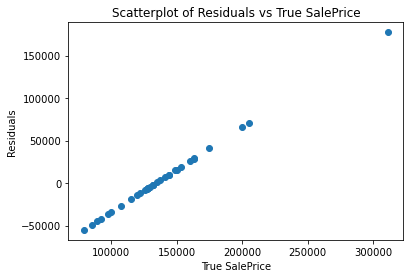

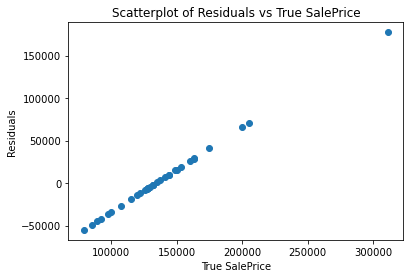

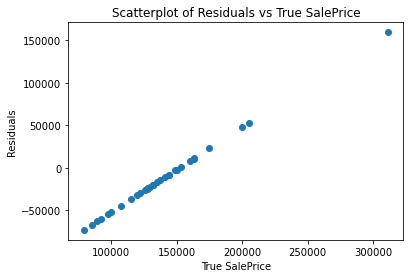

In [245]:
#Plot a scatterplot of the predicted vs the true value of the SalePrice

lasso_best = Lasso(alpha = lasso_housing_model.alpha_)
lasso_best.fit(X_train, y_train)

y_val_pred=lasso_best.predict(X_val)

residuals_lasso = y_val - y_val_pred

tree_reg = DecisionTreeRegressor(max_depth=5, random_state = 0)
tree_reg = tree_reg.fit(X_train, y_train)

y_val_pred=tree_reg.predict(X_val)

residuals_tree = y_val - y_val_pred

knn = KNeighborsRegressor(n_neighbors=8)
knn.fit(X_train, y_train)

y_val_pred=knn.predict(X_val)

residuals_knn = y_val - y_val_pred

plt.scatter(y_val, residuals_lasso)
plt.xlabel("True SalePrice")
plt.ylabel("Residuals")
plt.title("Scatterplot of Residuals vs True SalePrice")
plt.show()

plt.scatter(y_val, residuals_tree)
plt.xlabel("True SalePrice")
plt.ylabel("Residuals")
plt.title("Scatterplot of Residuals vs True SalePrice")
plt.show()

plt.scatter(y_val, residuals_knn)
plt.xlabel("True SalePrice")
plt.ylabel("Residuals")
plt.title("Scatterplot of Residuals vs True SalePrice")
plt.show()

*A histogram of errors could also give a good insight on any underlying patterns*

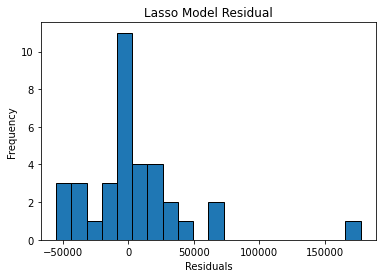

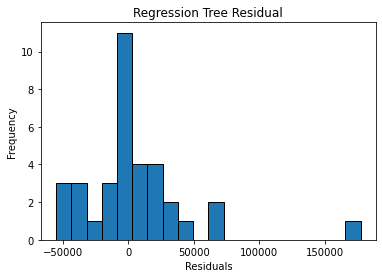

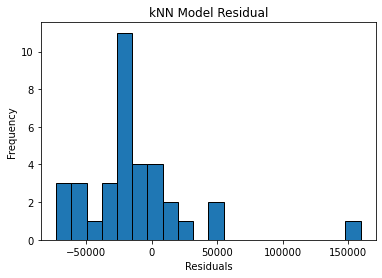

In [246]:
#Plot a histogram of the residuals. 

lasso_best = Lasso(alpha = lasso_housing_model.alpha_)
lasso_best.fit(X_train, y_train)

y_val_pred=lasso_best.predict(X_val)

residuals_lasso = y_val - y_val_pred

tree_reg = DecisionTreeRegressor(max_depth=5, random_state = 0)
tree_reg = tree_reg.fit(X_train, y_train)

y_val_pred=tree_reg.predict(X_val)

residuals_tree = y_val - y_val_pred

knn = KNeighborsRegressor(n_neighbors=8)
knn.fit(X_train, y_train)

y_val_pred=knn.predict(X_val)

residuals_knn = y_val - y_val_pred

plt.hist(residuals_lasso, bins=20, edgecolor="black")
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Lasso Model Residual')
plt.show()


plt.hist(residuals_tree, bins=20,edgecolor="black")
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Regression Tree Residual')
plt.show()

plt.hist(residuals_knn, bins=20, edgecolor="black")
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('kNN Model Residual')
plt.show()